In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import itertools
# for deepcopy
import pickle

In [2]:
class LinearProgram:
    def __init__(self, p_type, c, A, b):
        self.p_type = p_type
        self.c = c
        self.A = A
        self.b = b
        
        self.n_vars = A.shape[1]
        
        # add later
        self.A_slack = None

In [3]:
# stelle lp in standardform auf (2D)
c = np.array([-4, 1, -1]).reshape((-1, 1))
A = np.array([[1, 1, 1],[0, -1, -1], [2, 0, 1]])
b = np.array([5, -2, 1]).reshape((-1, 1))

lp1 = LinearProgram(p_type="min", c=c, A=A, b=b)

# ein lineares program ist von der form max c^Tx s.t. Ax <= b, x >= 0
c2 = np.array([-1, -2, -1]).reshape((-1, 1))
A2 = np.array([[1, 2, 0], [1, 1, 1], [2, 0, 1]])
b2 = np.array([5, 2, 1]).reshape((-1, 1))

lp2 = LinearProgram(p_type="min", c=c2, A=A2, b=b2)

# welches lineare Program soll gerade bearbeitet werden
lp = lp1

<IPython.core.display.Javascript object>


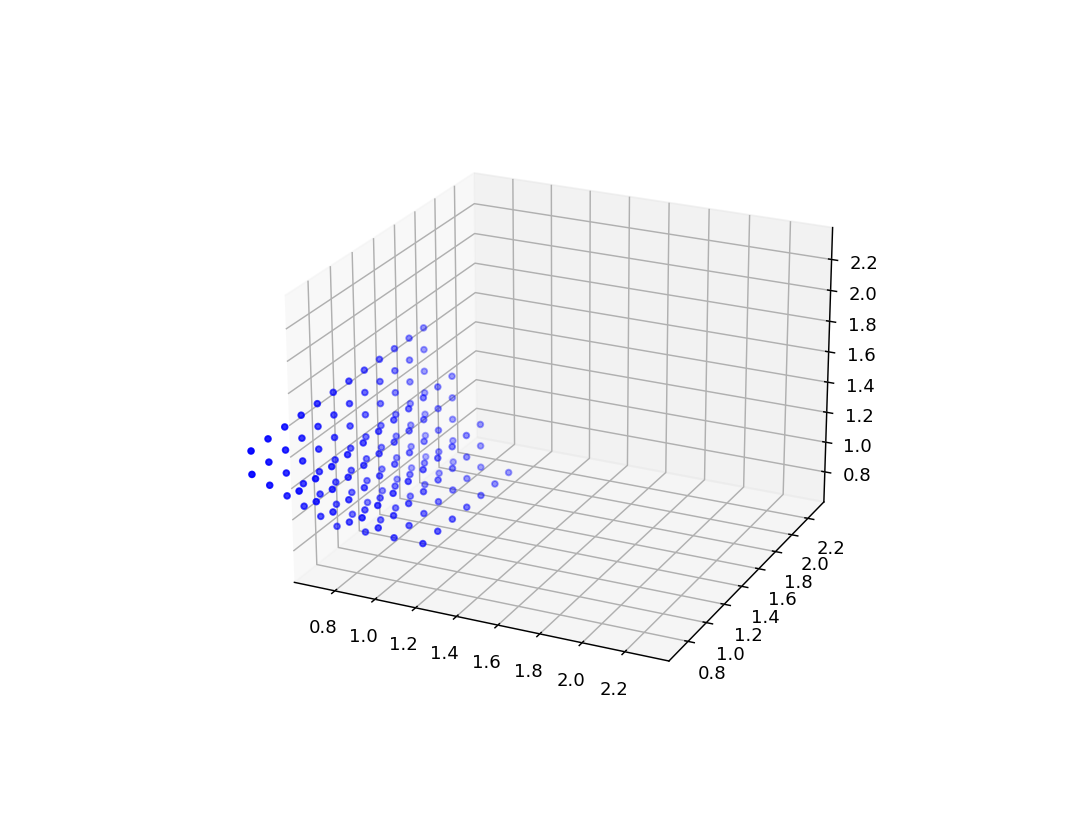

In [4]:
# plotte punkte, in feasible region in 2d
def plot_feasible_region(lp, max_val=5, n_samples_per_axis=10):
    
    samples_per_axis = np.linspace(0, max_val, n_samples_per_axis)
    sample_lists = [samples_per_axis for i in range(lp.n_vars)]
    
    xs = np.array([x for x in itertools.product(*sample_lists)])
    feasible_xs = []
    
    for x in xs:
        res = np.matmul(lp.A, x.reshape(-1, 1))
        if  np.all(res <= lp.b):
            feasible_xs.append(x)
    
    feasible_xs = np.array(feasible_xs)
    
    if lp.n_vars == 2:
        fig = plt.figure()
        
        ax = plt.gca()
        ax.set_title("Feasible Region")
        ax.scatter(feasible_xs[:, 0], feasible_xs[:, 1], c="blue", sizes=[10])
        ax.set_xlim([0, max_val])
        ax.set_ylim([0, max_val])
        plt.axis("equal")
        ax.quiver(0, 0, lp.c[0], lp.c[1], scale_units="xy", scale=1)
            
        return fig
        
        
    if lp.n_vars == 3:
        
        fig = plt.figure()
        
        ax = plt.axes(projection="3d")
        ax.scatter(feasible_xs[:, 0], feasible_xs[:, 1], feasible_xs[:, 2], c="blue", sizes=[10])
        ax.set_xlim([0, max_val])
        ax.set_ylim([0, max_val])
        ax.set_zlim([0, max_val])
        ax.quiver(0, 0, 0, lp.c[0], lp.c[1], lp.c[2])
        
        return fig
    
plt.ioff()

fig = plot_feasible_region(lp, max_val=3, n_samples_per_axis=20)
display(fig)

fig2 = pickle.loads(pickle.dumps(fig))

In [19]:
# wandle so um, dass Ax = b (indem slack-variablen hinzugefügt werden)
def add_slack_variables(lp):
    
    if lp.A_slack is None:
        n_inequalities = len(A)
        lp.A_slack = np.hstack([A, np.identity(n_inequalities)])
    
add_slack_variables(lp)
print("Add slack variables to A")
print(lp.A_slack)

Add slack variables to A
[[ 1.  1.  1.  1.  0.  0.]
 [ 0. -1. -1.  0.  1.  0.]
 [ 2.  0.  1.  0.  0.  1.]]


In [20]:

# finde alle eckpunkte des polyeders, indem du naive technik (basis finden, invertieren verwendest)
def find_basic_feasible_solutions(lp):
    
    # erwartet ein lineares program max c^T x s.t. Ax = b, x >= 0
    A = lp.A_slack
    
    n_basis = np.linalg.matrix_rank(A)
    
    potential_bases = list(itertools.combinations(range(A.shape[1]), n_basis))
    
    basic_feasible_solutions = []
    
    for potential_base in potential_bases:
        potential_base = list(potential_base)
        B = A[:, potential_base]
        
        if np.linalg.det(B) != 0:
            x_b = np.matmul(np.linalg.inv(B), lp.b)
            
            if np.all(x_b >= 0):
                x = np.zeros(A.shape[1])
                x[potential_base] = x_b.flatten()
                basic_feasible_solutions.append(x)
            
    return np.array(basic_feasible_solutions)

bfs = find_basic_feasible_solutions(lp)
print(bfs)

[[0.5 2.  0.  2.5 0.  0. ]
 [0.5 4.5 0.  0.  2.5 0. ]
 [0.  1.  1.  3.  0.  0. ]
 [0.  4.  1.  0.  3.  0. ]
 [0.  2.  0.  3.  0.  1. ]
 [0.  5.  0.  0.  3.  1. ]]


In [21]:
def get_optimal_solution(lp, bfs):
    
    bfs_clipped = bfs[:, :lp.n_vars]
    costs = np.sum(lp.c.flatten() * bfs_clipped, axis=1)
    
    optimal_idx = np.argmin(costs) if lp.p_type == "min" else np.argmax(costs)
    optimal_x = bfs[optimal_idx]
    optimal_cost = costs[optimal_idx]
    
    return optimal_x, optimal_cost

<IPython.core.display.Javascript object>


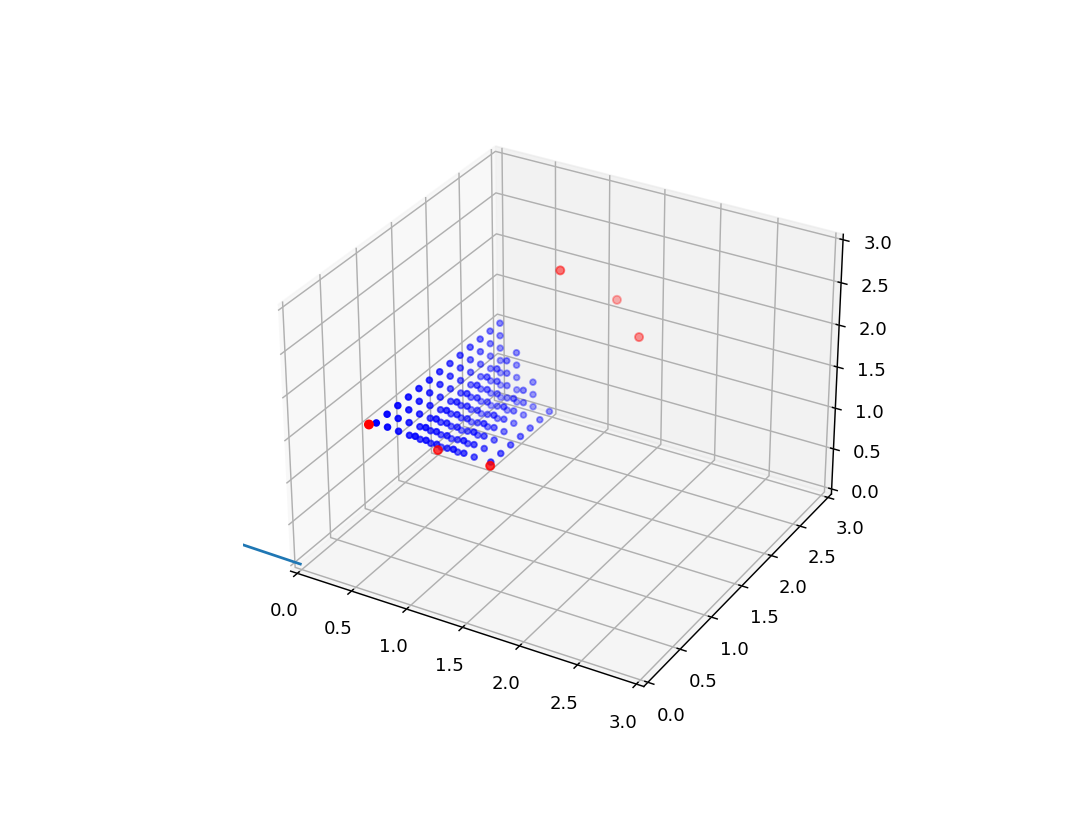

The optimal solution [0.5 2.  0.  2.5 0.  0. ] has the min costs of 0.0


In [22]:
def plot_bfs(lp, bfs):
    ax = fig2.axes[0]
    
    if lp.n_vars == 2:
        ax.scatter(bfs[:, 0], bfs[:, 1], c="red")

    elif lp.n_vars == 3:
        ax.scatter(bfs[:, 0], bfs[:, 1], bfs[:, 2], c="red")

    display(fig2)

plot_bfs(lp, bfs)

optimal_x, optimal_cost = get_optimal_solution(lp, bfs)
print(f"The optimal solution {optimal_x} has the {lp.p_type} costs of {optimal_cost}")

In [ ]:
# finde start mit simplex und zeichne simplex weg